In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import cohen_kappa_score
from numpy import linspace

In [2]:
# suppress Convergence and user Warnings

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Parameters
the modeling process is affected by a number of parameters, descriptions are included

#### test run
restricts the size of the data set to 500 compounds when enabled. Imbalanced category ratios of the complete data set will be kept in the downsized data set

In [3]:
# True: randomly chooses 500 compounds from the data set
# False: use the entire data set for the modeling

test_run = False
#test_run = True

#### predict test set
testing data and the submission template will only be read and a prediction will only occur if 'pred' is set to true

In [4]:
# True: predict test data set

pred = True
#pred = false

#### StandardScaler
the usage of StandardScaler before the modeling will affect the prediction score, positive and negative effects have been observed

In [5]:
# True: use Standard Scaler

StdSca = True
#StdSca = False

#### save prediction as csv
independent of the value of 'save', the submission file will only be saved if 'test_run' is set to false and 'pred' is set to true

In [6]:
# True: save prediction as csv file

save = False
#save = True

## Reading data sets
the test data set and submission template will only be read in if 'pred' is set to true to save time for validation runs without predictions

In [7]:
df = pd.read_csv('output/df_train_set.csv')
df['sol_category'] = pd.to_numeric(df['sol_category'], downcast='integer')

if pred:
    df_test_set = pd.read_csv('output/df_test_set.csv')
    sub_template = pd.read_csv('Data/submission_template_rdm.csv')

#### checking the composition of the data set

In [8]:
df['sol_category'].value_counts()

2    65835
1     2835
0     2041
Name: sol_category, dtype: int64

In [23]:
df['sol_category'].value_counts(normalize=True)

2    0.931043
1    0.040093
0    0.028864
Name: sol_category, dtype: float64

for 'test_run' set to true, the size of the data set will be restricted to 500 compounds. The category ratios in case of data set imbalance will be kept due to the stratify command

In [9]:
if test_run:
    df, _, __, ___ = train_test_split(df, df['sol_category'], train_size=500, stratify=df['sol_category'])

## preparing model training data

#### defining features X

In [10]:
X = df.copy(deep=True)
X.drop(columns=['Id', 'smiles', 'sol_category'], inplace=True)
#X

#### defining category list y

In [11]:
y = df.iloc[:, 2]

## training model

#### defining parameters for the xgboost model

In [12]:
# setup parameters for the xgboost model
params = {}
#params['booster'] = 'gbtree' #['gbtree', 'gblinear', 'dart']
#params['objective'] = ['binary:logistic']
#params["eval_metric"] = ["error"]
params['eta'] = 0.001 #, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5] # boosting learning rate
params['gamma'] = 0.5 #linspace(0.000000001, 1.0, num=11) # min loss red recuired for further partition on leaf node
params['max_depth'] = 7 #np.arange(1, 11, 2) # max tree dept for base learners
params['n_estimators'] = 100 #np.arange(50, 550, 50) maybe 250 ??
params['min_child_weight'] = 1 # min sum of instance weight in a child
params['max_delta_step'] = 0 # max delta step allowed for each tree's weight estimate
params['subsample']= 0.5 #[0.5, 1] # subsample ratio of training instance
params['colsample_bytree'] = 1 # subsample ratio of columns when cunstructing each tree
#params['silent'] = [1]
#params['seed'] = [0] # = random_state ???
params['base_score'] = 0.5 # initial prediction score, global bias
#params['random_state'] = [0] # = seed ???
#params['scale_pos_weight'] = ratio
params['n_jobs'] = 5

#### applying model on training data set
the XGBoost model is trained on an 0.8 split of the training data set with the remaining 0.2 of the data set to be used for the validation score. Classes are weighted on their ratio for the training. The score is a quadratically weighted cohen's kappa score,

In [13]:
# applying StandardScaler
if StdSca:
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X)
    X = scaler.fit_transform(X)

# splitting data set
StratifiedKFold(n_splits=5)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1,  shuffle=True, stratify=y)#, test_size=0.2, train_size=0.8)

# defining class weights
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
    )

# defining model
model = XGBClassifier(**params)

# fitting model on training data set
model.fit(X_train, y_train, sample_weight=classes_weights)

# model validation
valPredictions = model.predict(X_val)

# calculating quadratically weighted kappa score
sk_quad_kappa = cohen_kappa_score(y_val, valPredictions, weights='quadratic')
    
 
# printing results
print(f'quadratically weighted kappa validation score: {sk_quad_kappa}')

quadratically weighted kappa validation score: 0.08301296438048156


## predicting test set
prediction only occurs for 'pred' set to true

In [14]:
if pred:
    df_test_set.drop(columns=['Id', 'smiles'], inplace=True)

    # apply StandardScaler
    if StdSca:
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(df_test_set)
        df_test_set = scaler.fit_transform(df_test_set)

    # prediction
    testPredictions = model.predict(df_test_set)
    sub_template['pred'] = testPredictions

list of all predicted categories

In [21]:
if pred:
    print(set(testPredictions))

{0, 1, 2}


value cont of the prediction

In [22]:
if pred:
    print(sub_template['pred'].value_counts())

2    26740
1     2296
0     1271
Name: pred, dtype: int64


## Save as csv file
the submission will only be saved if 'test_run' is set to false and 'pred' is set to true

In [17]:
if save:
    if test_run:
        print('attempted to save a test run')
    elif pred:
        sub_template.to_csv('Submissions/submission_21_12_C-lab.csv', index=False)
        print('submission file saved as csv')
    else:
        print('predictions not calculated, submission cannot be saved as csv file')
else:
    if test_run:
        print('unsaved test run')
    else:
        print('unsaved run')

saving as csv planned


## 2 component PCA plot

In [41]:
df_X = pd.DataFrame(X_train)

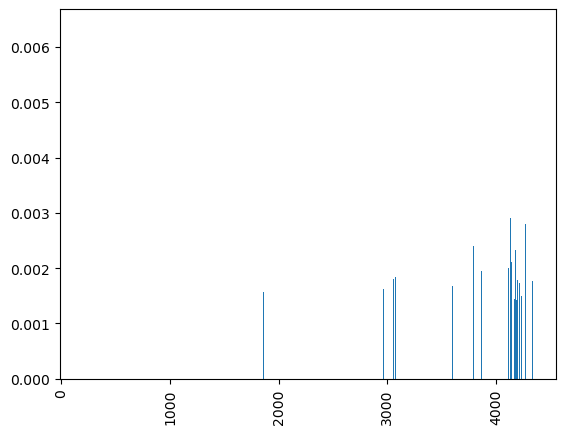

In [42]:
importance_df = pd.DataFrame(data={
    'feature': df_X.columns,
    'importance': model.feature_importances_
}).sort_values(by=['importance'], ascending=False)#.head(200)

#importance_df = importance_df[importance_df['feature'].str.contains('ecfp')==False]
#importance_name_df = df[[col for col in df.columns if (col.startswith('rdkit_') or col.startswith('example_'))]]

import matplotlib.pyplot as plt
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.show()